# Blade number detection demo
This code is originally taken from the object detection demo from Google, called: "object_detection_tutorial.ipynb". In this notebook a demo is presented on how to detect numbers from a (turbine) blade. Here I used transfer learning to customize the Faster-RCNN-Inception-V2-COCO model creating a customized model for detecting number objects in an image with numbers on a turbine blade. 

Make sure to first follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

This demo is created by Niels Rozeboom (2019)

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
# from matplotlib import pyplot as plt
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Object detection imports
Here are the imports from the object detection module.

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
CWD_PATH = os.getcwd()
PATH_TO_FROZEN_GRAPH = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
PATH_TO_LABELS = os.path.join(CWD_PATH,'labels.pbtxt')

In [13]:
# name of input image
INPUT_IMAGE = '1sn_7.jpg'

# name of directory and name of output image
OUTPUT_DIR = 'output'
OUTPUT_IMAGE = '1sn_output.jpg'
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_DIR, OUTPUT_IMAGE)

## Download Model

## Load a (frozen) Tensorflow model into memory.

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to number 5 from the image.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [15]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [17]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '.\\images'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '1sn_{}.jpg'.format(i)) for i in range(2, 3) ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, INPUT_IMAGE) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (15, 10)

In [18]:
# a simple method to convert a list 
# of integers into a single integer 
def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
      
    # Join list items using join() 
    res = int("".join(s)) 
      
    return(res) 

In [19]:
# method for getting all inference data from one image detecting numbers
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

# Run inference on image(s)

In [20]:
# run script for all images. In this script we just 1 image. This image will be saved in the output folder
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.savefig(OUTPUT_IMAGE_PATH)


In [21]:
# create lists for score, classes and area boxes
score = []
detect_class = []
box = []

In [22]:
# fill lists with values from image where probability of found number is higher than 90%
for i in range(output_dict['detection_classes'].shape[0]):
    if output_dict['detection_scores'][i] > 0.90:
        score.append(output_dict['detection_scores'][i])
        detect_class.append(output_dict['detection_classes'][i])
        box.append(output_dict['detection_boxes'][i][1])

In [23]:
# create dataframe with all relevant inference data from the image order from left to right 
data = {'score': score, 'detect_class' : detect_class, 'box' : box}
df = pd.DataFrame(data)
df = df.sort_values(by=['box'])
df = df.replace(10, 0)

In [24]:
# convert the list with numbers to a string
numbers_detected = list(df['detect_class'])
number = ''
if numbers_detected:
    number = convert(numbers_detected) 

# Inference Result

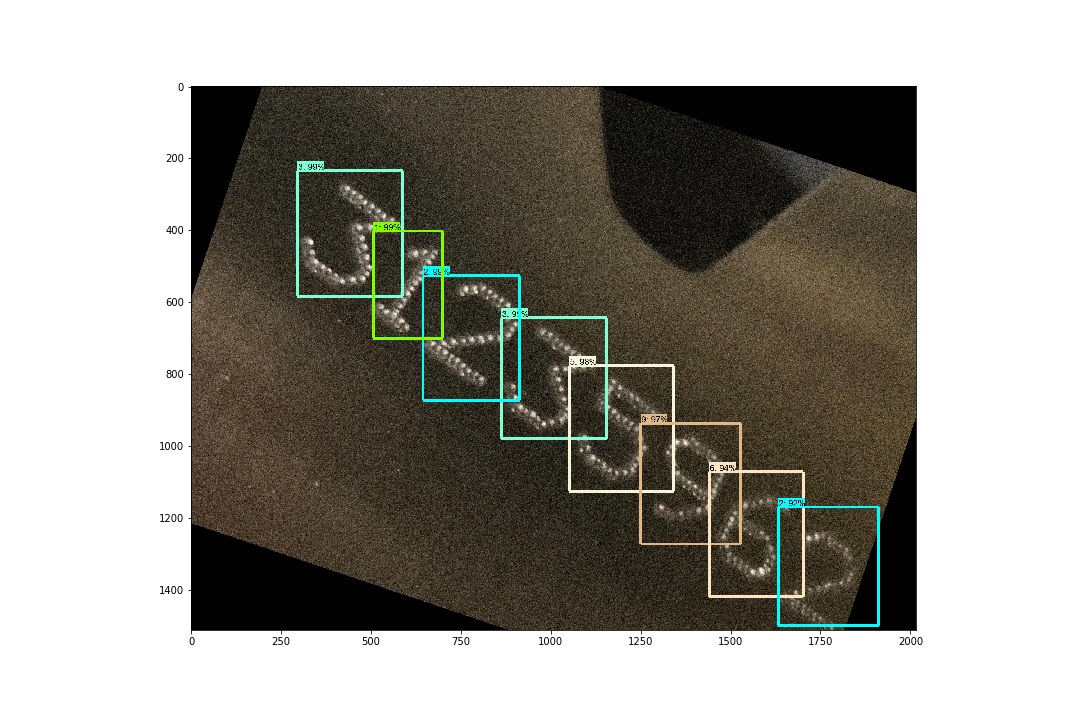

In [25]:
# display image with 
Image.open(OUTPUT_IMAGE_PATH)

In [26]:
# outcome: display the number on the image of the turbine blade
from IPython.display import display, Markdown
if number:
    Markdown('above image contains following number: <h1>{}</h1>'.format(number))